# Assignment 5: UCB, Non-Stationary Bandits, and Naive Algorithm

This notebook covers:
1. UCB solution for Stationary and Non-Stationary environments.
2. Comparison of Sample Average vs Constant Alpha updates in Non-Stationary environments.
3. Implementation of the Naive (Explore-Then-Commit) algorithm.
4. Sensitivity analysis for Naive algorithm parameters ($\epsilon$ and $\delta$).

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Global settings for plot aesthetics
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

In [9]:
class StationaryBandit:
    def __init__(self, n_arms=10):
        self.n_arms = n_arms
        self.q_true = np.random.normal(0, 1, n_arms)
    
    def step(self, action):
        reward = np.random.normal(self.q_true[action], 1)
        return reward
    
    def optimal_action(self):
        return np.argmax(self.q_true)

class NonStationaryBandit:
    def __init__(self, n_arms=10):
        self.n_arms = n_arms
        # Initialize all q(a) equal to 0 as per standard non-stationary problem (or N(0,1))
        # Usually N(0,0) init is used for pure random walk demonstrations
        self.q_true = np.zeros(n_arms) 
    
    def step(self, action):
        reward = np.random.normal(self.q_true[action], 1)
        # Random walk for all arms: mean 0, std 0.01
        self.q_true += np.random.normal(0, 0.01, self.n_arms)
        return reward
    
    def optimal_action(self):
        return np.argmax(self.q_true)

In [10]:
def run_bandit_experiment(agent_type, env_type='stationary', runs=2000, steps=1000, **kwargs):
    """
    Generic experiment runner.
    agent_type: 'ucb' or 'epsilon_greedy'
    env_type: 'stationary' or 'non_stationary'
    kwargs: parameters for agents (epsilon, alpha, c_lvl)
    """
    n_arms = 10
    avg_rewards = np.zeros(steps)
    optimal_actions = np.zeros(steps)
    
    for r in range(runs):
        if env_type == 'stationary':
            env = StationaryBandit(n_arms)
        else:
            env = NonStationaryBandit(n_arms)
            
        Q = np.zeros(n_arms)
        N = np.zeros(n_arms)
        
        # Hyperparameters
        epsilon = kwargs.get('epsilon', 0.1)
        alpha = kwargs.get('alpha', None) # If None -> Sample Average
        c_lvl = kwargs.get('c', 2) # For UCB
        
        for t in range(steps):
            # Action Selection
            if agent_type == 'ucb':
                # Avoid division by zero by considering 0-count arms as infinities
                # Standard UCB: Q(a) + c * sqrt(ln(t)/N(a))
                ucb_est = np.zeros(n_arms)
                for a in range(n_arms):
                    if N[a] == 0:
                        ucb_est[a] = float('inf')
                    else:
                        ucb_est[a] = Q[a] + c_lvl * np.sqrt(np.log(t + 1) / N[a])
                action = np.argmax(ucb_est)
                
            elif agent_type == 'epsilon_greedy':
                if np.random.rand() < epsilon:
                    action = np.random.randint(n_arms)
                else:
                    # Break ties randomly
                    max_q = np.max(Q)
                    candidates = np.where(Q == max_q)[0]
                    action = np.random.choice(candidates)
            
            # Step Environment
            reward = env.step(action)
            
            # Record Stats
            avg_rewards[t] += reward
            if action == env.optimal_action():
                optimal_actions[t] += 1
            
            # Update Q-Values
            N[action] += 1
            
            if alpha is None: 
                # Sample Average
                step_size = 1.0 / N[action]
            else:
                # Constant Alpha
                step_size = alpha
                
            Q[action] += step_size * (reward - Q[action])
            
    return avg_rewards / runs, optimal_actions / runs

Running Task 1 Experiments...
  - UCB (Stationary)
  - UCB (Non-Stationary)
  - E-Greedy Sample Avg (Non-Stationary)
  - E-Greedy Constant Alpha (Non-Stationary)


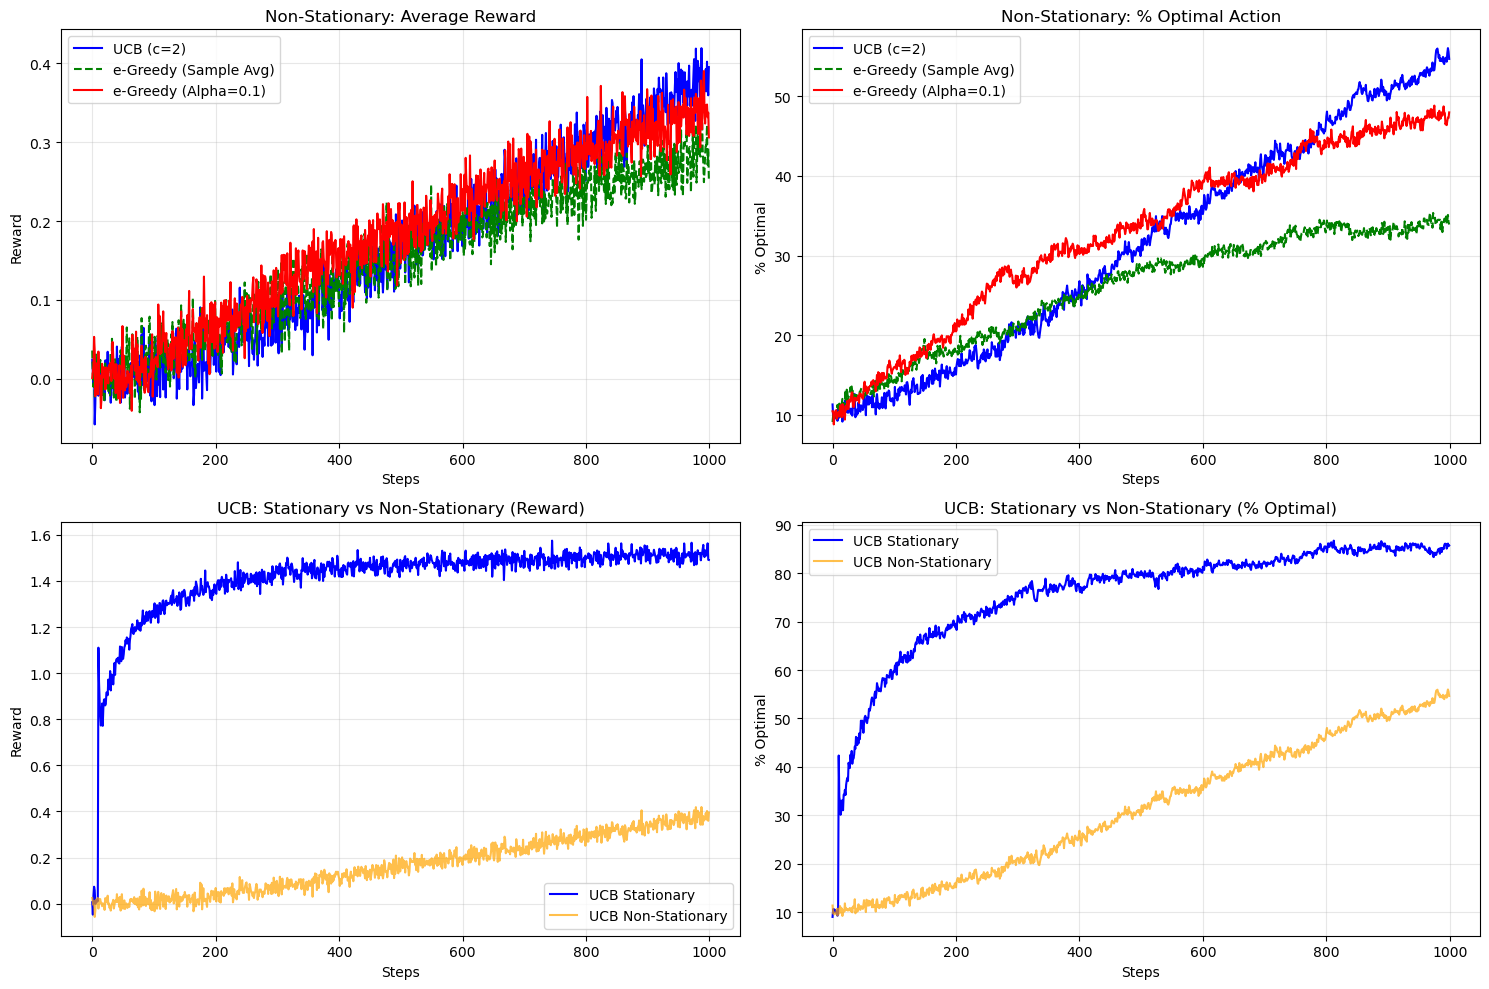

In [11]:
# --- Task 1: UCB and Parameter Comparison ---

runs = 2000  # Increased to 2000 to reduce sampling variance
steps = 1000

print("Running Task 1 Experiments...")

# 1. UCB Stationary
print("  - UCB (Stationary)")
rew_ucb_stat, opt_ucb_stat = run_bandit_experiment('ucb', 'stationary', runs, steps, c=2)

# 2. UCB Non-Stationary
print("  - UCB (Non-Stationary)")
rew_ucb_non, opt_ucb_non = run_bandit_experiment('ucb', 'non_stationary', runs, steps, c=2)

# 3. Epsilon-Greedy Sample Average (Non-Stationary)
print("  - E-Greedy Sample Avg (Non-Stationary)")
rew_eg_sa, opt_eg_sa = run_bandit_experiment('epsilon_greedy', 'non_stationary', runs, steps, epsilon=0.1, alpha=None)

# 4. Epsilon-Greedy Constant Alpha (Non-Stationary)
print("  - E-Greedy Constant Alpha (Non-Stationary)")
rew_eg_const, opt_eg_const = run_bandit_experiment('epsilon_greedy', 'non_stationary', runs, steps, epsilon=0.1, alpha=0.1)


# Plotting Task 1
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Stationary Plot (Just UCB mostly as baseline, but plot is focused on comparisons)
# Let's plot Non-Stationary Comparisons mainly as requested for "Alpha vs Sample Avg"
# Plot 1: Non-Stationary Average Reward
ax = axes[0, 0]
ax.plot(rew_ucb_non, label='UCB (c=2)', color='blue')
ax.plot(rew_eg_sa, label='e-Greedy (Sample Avg)', color='green', linestyle='--')
ax.plot(rew_eg_const, label='e-Greedy (Alpha=0.1)', color='red')
ax.set_title('Non-Stationary: Average Reward')
ax.set_xlabel('Steps')
ax.set_ylabel('Reward')
ax.legend()

# Plot 2: Non-Stationary % Optimal
ax = axes[0, 1]
ax.plot(opt_ucb_non * 100, label='UCB (c=2)', color='blue')
ax.plot(opt_eg_sa * 100, label='e-Greedy (Sample Avg)', color='green', linestyle='--')
ax.plot(opt_eg_const * 100, label='e-Greedy (Alpha=0.1)', color='red')
ax.set_title('Non-Stationary: % Optimal Action')
ax.set_xlabel('Steps')
ax.set_ylabel('% Optimal')
ax.legend()

# Plot 3: Stationary UCB Baseline (for reference)
ax = axes[1, 0]
ax.plot(rew_ucb_stat, label='UCB Stationary', color='blue')
ax.plot(rew_ucb_non, label='UCB Non-Stationary', color='orange', alpha=0.7)
ax.set_title('UCB: Stationary vs Non-Stationary (Reward)')
ax.set_xlabel('Steps')
ax.set_ylabel('Reward')
ax.legend()

# Plot 4: Stationary UCB Baseline (% Optimal)
ax = axes[1, 1]
ax.plot(opt_ucb_stat * 100, label='UCB Stationary', color='blue')
ax.plot(opt_ucb_non * 100, label='UCB Non-Stationary', color='orange', alpha=0.7)
ax.set_title('UCB: Stationary vs Non-Stationary (% Optimal)')
ax.set_xlabel('Steps')
ax.set_ylabel('% Optimal')
ax.legend()

plt.tight_layout()
plt.show()

In [12]:
def run_naive_experiment(epsilon, delta, runs=500, steps=1000):
    """
    Naive PAC-style Algorithm:
    1. Calculate samples needed per arm: m = (4/epsilon^2) * ln(2*n/delta) 
       (Note: Specific formula may vary by lecture resource, utilizing a standard PAC bound here. 
        Assuming n=10 arms)
    2. Sample each arm m times.
    3. Pick best arm and play till end.
    """
    n_arms = 10
    avg_rewards = np.zeros(steps)
    optimal_actions = np.zeros(steps)
    
    # Calculate exploration phase length per arm
    # m = ceil( 4 / epsilon^2 * log(2*n_arms / delta) )
    # This is a theoretical bound. For practical plotting within 1000 steps, 
    # if m is too large, we might cap it or the plot will just be flat exploring.
    # Let's use the formula directly.
    
    try:
        m = int(np.ceil((4 / (epsilon**2)) * np.log(2 * n_arms / delta)))
    except:
        m = steps # Safety
        
    # Total exploration steps
    total_exploration = m * n_arms
    
    # If exploration takes longer than simulation, we just explore
    if total_exploration > steps:
        print(f"Warning: Epsilon {epsilon}, Delta {delta} requires {total_exploration} steps to explore, but only {steps} available.")
    
    for r in range(runs):
        env = StationaryBandit(n_arms)
        
        # Empirical sums and counts
        # We don't really update them step-by-step for decision making in pure exploration
        # But we need to track them to find the best at the end of exploration
        arm_rewards = np.zeros(n_arms)
        arm_counts = np.zeros(n_arms)
        
        # Phase 1: Pure Exploration
        # We iterate through steps. If t < total_exploration, we round-robin sample.
        
        best_arm_cache = None
        
        for t in range(steps):
            if t < total_exploration:
                # Round robin selection
                action = t % n_arms
                reward = env.step(action)
                
                arm_rewards[action] += reward
                arm_counts[action] += 1
                
                # In exploration, we don't 'exploit' optimality yet, but we track if we hit it by chance
                if action == env.optimal_action():
                    optimal_actions[t] += 1
                avg_rewards[t] += reward
                
            else:
                # Phase 2: Exploit
                # Calculate best arm once at the transition
                if best_arm_cache is None:
                    # Compute mean rewards
                    means = arm_rewards / np.maximum(arm_counts, 1)
                    best_arm_cache = np.argmax(means)
                
                action = best_arm_cache
                reward = env.step(action)
                
                avg_rewards[t] += reward
                if action == env.optimal_action():
                    optimal_actions[t] += 1
                    
    return avg_rewards / runs, optimal_actions / runs, total_exploration


Running Task 2: Naive Algorithm (e=0.1, delta=0.05)...
  -> Calculated samples per arm (m): 2397
  -> Total exploration steps: 23970


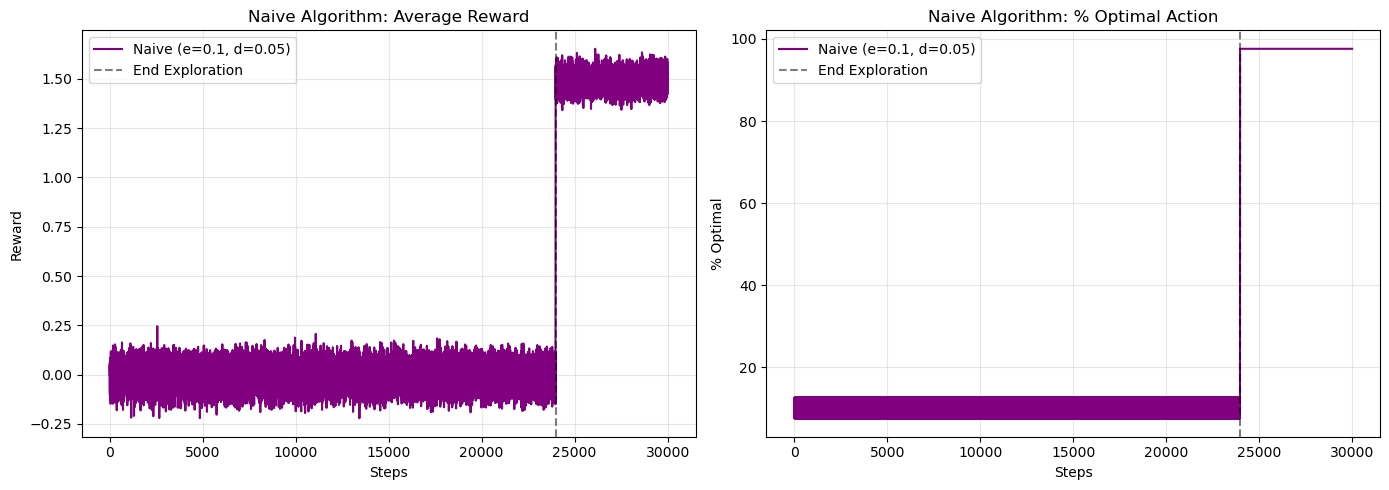

In [13]:
# --- Task 2: Naive Algorithm Single Run (e=0.1, delta=0.05) ---
steps_naive = 30000 # Increased steps to accommodate large 'm' exploration phase
print("\nRunning Task 2: Naive Algorithm (e=0.1, delta=0.05)...")

epsilon_task2 = 0.1
delta_task2 = 0.05

# Increased runs to 500 for smoother graph
rew_naive, opt_naive, expl_steps = run_naive_experiment(epsilon_task2, delta_task2, runs=500, steps=steps_naive)
print(f"  -> Calculated samples per arm (m): {expl_steps // 10}")
print(f"  -> Total exploration steps: {expl_steps}")


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(rew_naive, label=f'Naive (e={epsilon_task2}, d={delta_task2})', color='purple')
plt.axvline(x=expl_steps, color='k', linestyle='--', alpha=0.5, label='End Exploration')
plt.title('Naive Algorithm: Average Reward')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(opt_naive * 100, label=f'Naive (e={epsilon_task2}, d={delta_task2})', color='purple')
plt.axvline(x=expl_steps, color='k', linestyle='--', alpha=0.5, label='End Exploration')
plt.title('Naive Algorithm: % Optimal Action')
plt.xlabel('Steps')
plt.ylabel('% Optimal')
plt.legend()

plt.tight_layout()
plt.show()


Running Task 3: Parameter Sensitivity...


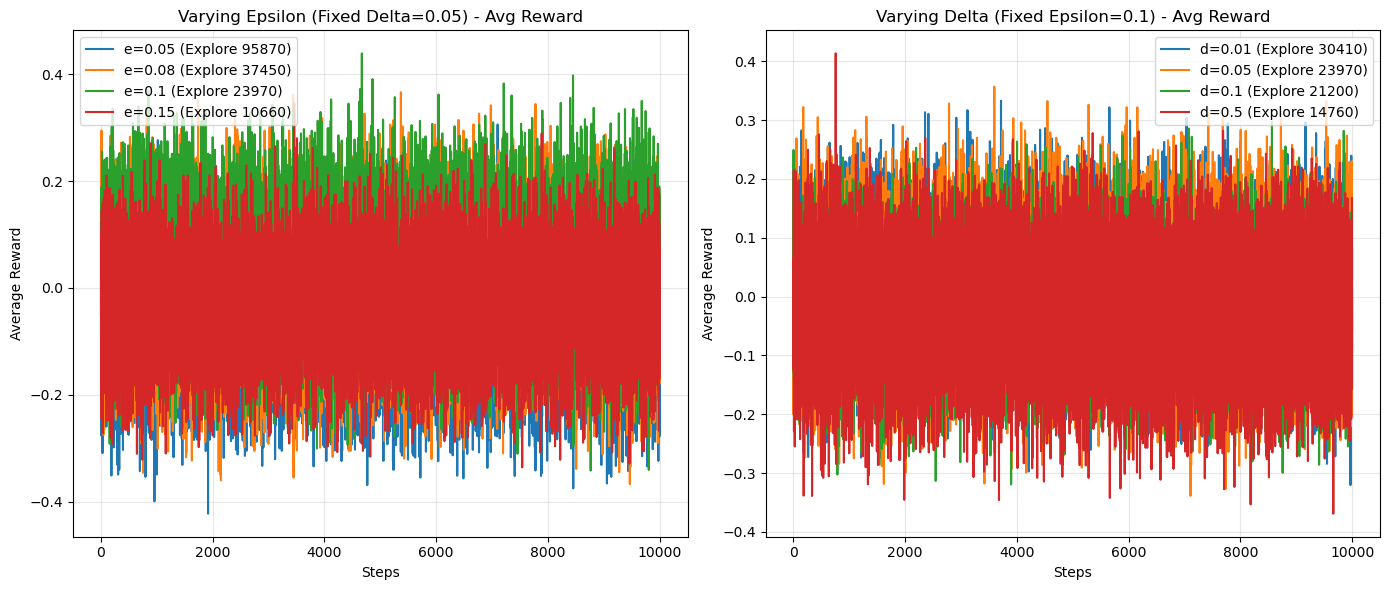

In [14]:
# --- Task 3: Parameter Sensitivity for Epsilon and Delta ---
print("\nRunning Task 3: Parameter Sensitivity...")

# Plot 1: Vary Epsilon (delta fixed at 0.05)
eps_values = [0.05, 0.08, 0.1, 0.15] # 0.01 is often too small -> m is huge -> exploration > steps
fixed_delta = 0.05
steps_sens = 10000 # Need more steps to see transitions for small epsilon

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for eps in eps_values:
    # Increased runs to 200 for better stability
    r, _, es = run_naive_experiment(eps, fixed_delta, runs=200, steps=steps_sens)
    plt.plot(r, label=f'e={eps} (Explore {es})')

plt.title(f'Varying Epsilon (Fixed Delta={fixed_delta}) - Avg Reward')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()


# Plot 2: Vary Delta (epsilon fixed at 0.1)
delta_values = [0.01, 0.05, 0.1, 0.5]
fixed_eps = 0.1

plt.subplot(1, 2, 2)
for d in delta_values:
    # Increased runs to 200 for better stability
    r, _, es = run_naive_experiment(fixed_eps, d, runs=200, steps=steps_sens)
    plt.plot(r, label=f'd={d} (Explore {es})')

plt.title(f'Varying Delta (Fixed Epsilon={fixed_eps}) - Avg Reward')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()

plt.tight_layout()
plt.show()